In [ ]:
# ============================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from textblob import TextBlob
from sklearn.cluster import KMeans
import re

In [ ]:
# Configure default visual settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [ ]:
# ============================================
# STEP 2: LOAD THE DATASET
# ============================================

# Load Excel file (adjust file path accordingly)
xls = pd.ExcelFile("/content/drive/MyDrive/Business Applications/W19310-XLS-ENG.xlsx")

# Load sheets
tweets_df_raw = pd.read_excel(xls, sheet_name='Tweets Data')
retweets_df_raw = pd.read_excel(xls, sheet_name='Retweets Data ')
users_df_raw = pd.read_excel(xls, sheet_name='Twitter User Data')

In [ ]:
# ============================================
# STEP 3: CLEAN TWEETS DATA
# ============================================

# Skip the first row (header row inside data)
tweets_df = tweets_df_raw[1:].copy()
tweets_df.columns = tweets_df_raw.iloc[0]

# Rename relevant columns
tweets_df = tweets_df.rename(columns={
    'Vertex 1': 'User',
    'Vertex 2': 'TargetUser',
    'Tweet': 'TweetText',
    'Tweet Date (UTC)': 'TweetDate',
    'Imported ID': 'TweetID'
})

# Normalize usernames (lowercase and strip whitespace)
for col in ['User', 'TargetUser']:
    tweets_df[col] = tweets_df[col].str.lower().str.strip()

# Drop rows with missing Tweet ID or Text
tweets_df = tweets_df.dropna(subset=['TweetID', 'TweetText'])

# Label whether tweet is from Xoxoday or a user
tweets_df['TweetSource'] = tweets_df['User'].apply(lambda x: 'Company' if x == 'thexoxoday' else 'User')

# Remove self-mentions (user tagging themselves)
tweets_df = tweets_df[tweets_df['User'] != tweets_df['TargetUser']]

# Keep only relevant columns
tweets_df = tweets_df[['TweetID', 'User', 'TargetUser', 'TweetText', 'TweetDate', 'TweetSource']]

In [ ]:
 # ============================================
# STEP 4: CREATE UNIQUE TWEET DATASET
# ============================================

# Remove duplicate tweets (based on TweetID) for sentiment analysis
tweets_unique = tweets_df.drop_duplicates(subset='TweetID').copy()
tweets_unique.reset_index(drop=True, inplace=True)

# Preview cleaned tweet data
tweets_unique.head()

,TweetID,User,TargetUser,TweetText,TweetDate,TweetSource
0,824217142681862144,sanchitabhartiy,thexoxoday,RT @thexoxoday: Our #Contest is #live! #RT and...,2017-01-25 11:27:34,User
1,824218047707652096,ratneshnagori,divyamisra2,@thexoxoday @kunalgupta09 @ekta_k88 @kp_85 @sn...,2017-01-25 11:31:10,User
2,824218070931492864,ratneshnagori,thexoxoday,RT @thexoxoday: Our #Contest is #live! #RT and...,2017-01-25 11:31:15,User
3,824219424135598080,ankitajain0911,minty_tweets,@thexoxoday Join in\n@ajayhere @Riannaoliver @...,2017-01-25 11:36:38,User
4,824220271393443840,ankitajain0911,piratedmarwadi,"@thexoxoday If I were to win this #contest, I'...",2017-01-25 11:40:00,User


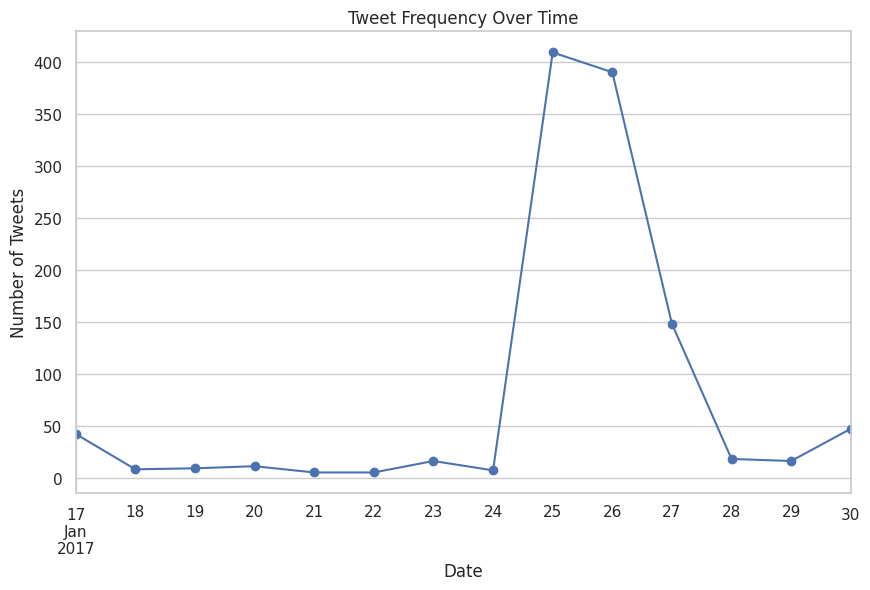

In [ ]:
# Tweet Volume Over Time
tweets_unique['TweetDate'] = pd.to_datetime(tweets_unique['TweetDate'])
tweets_unique.set_index('TweetDate').resample('D').size().plot(kind='line', marker='o')
plt.title('Tweet Frequency Over Time')
plt.ylabel('Number of Tweets')
plt.xlabel('Date')
plt.show()


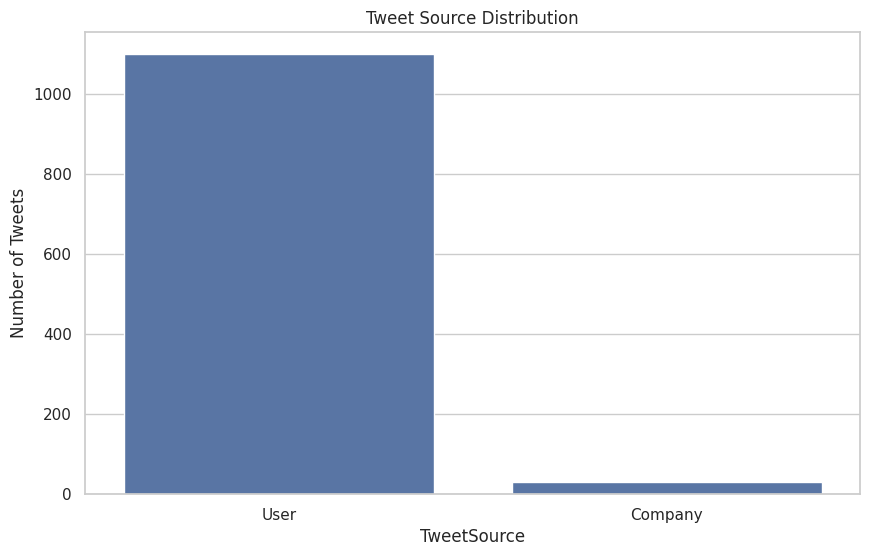

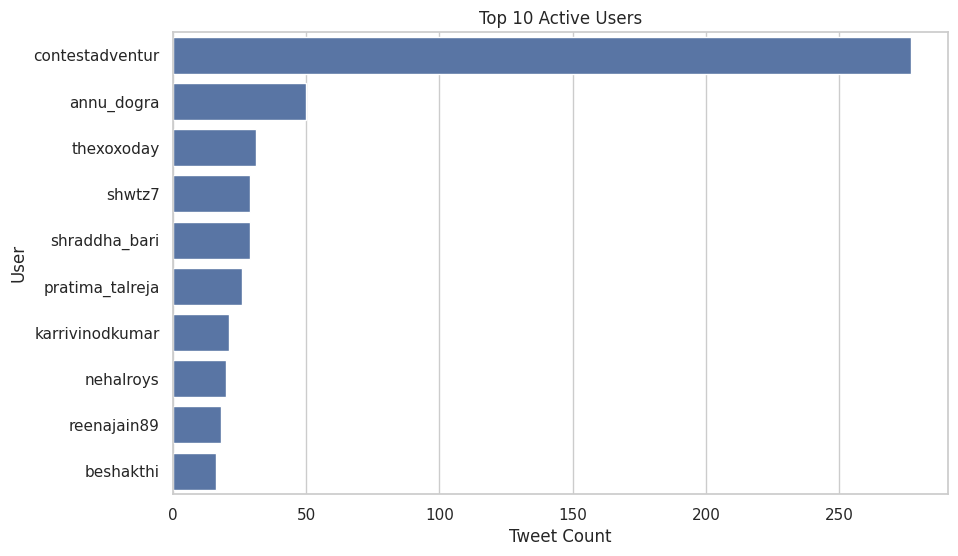

In [ ]:
# Tweet source distribution
sns.countplot(data=tweets_unique, x='TweetSource')
plt.title("Tweet Source Distribution")
plt.ylabel("Number of Tweets")
plt.show()

# Top users by tweet count
top_users = tweets_unique['User'].value_counts().head(10)
sns.barplot(y=top_users.index, x=top_users.values)
plt.title("Top 10 Active Users")
plt.xlabel("Tweet Count")
plt.ylabel("User")
plt.show()

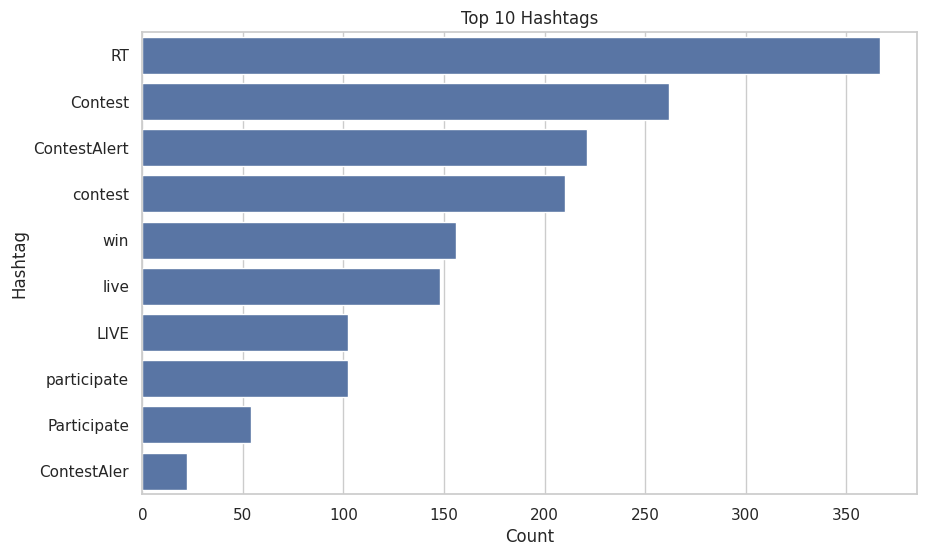

In [ ]:
import collections

# Extract hashtags from tweets
hashtags = tweets_unique['TweetText'].str.extractall(r"#(\w+)")[0]
top_hashtags = hashtags.value_counts().head(10)

sns.barplot(x=top_hashtags.values, y=top_hashtags.index)
plt.title("Top 10 Hashtags")
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.show()


In [ ]:
# ============================================
# STEP 1: TEXT CLEANING FOR SENTIMENT
# ============================================
def clean_tweet(text):
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"http\S+|www.\S+", "", text)  # Remove URLs
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # Remove special characters
    return text.lower().strip()

# Apply cleaning
tweets_unique['CleanedText'] = tweets_unique['TweetText'].apply(clean_tweet)


In [ ]:
# ============================================
# STEP 2: APPLY TEXTBLOB SENTIMENT ANALYSIS
# ============================================
def get_sentiment(text):
    blob = TextBlob(text)
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

tweets_unique[['Polarity', 'Subjectivity']] = tweets_unique['CleanedText'].apply(get_sentiment)

# Categorize Sentiment
def categorize(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

tweets_unique['SentimentCategory'] = tweets_unique['Polarity'].apply(categorize)


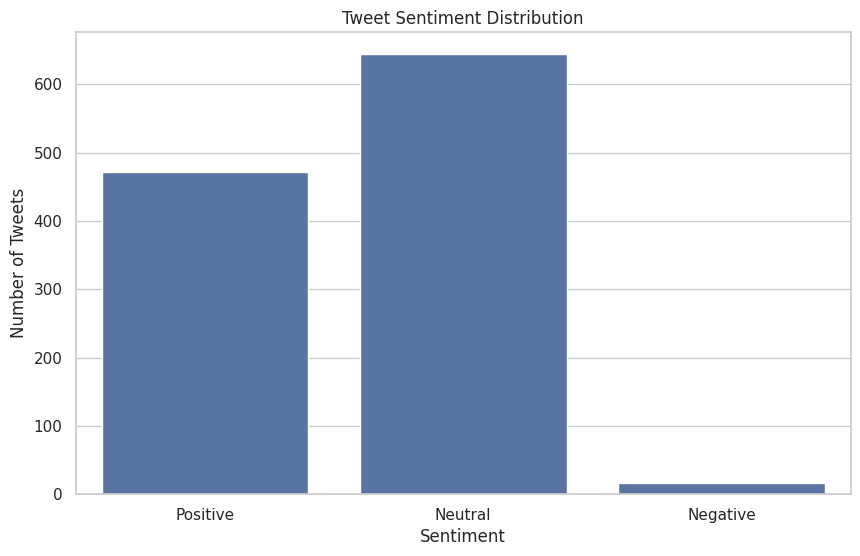

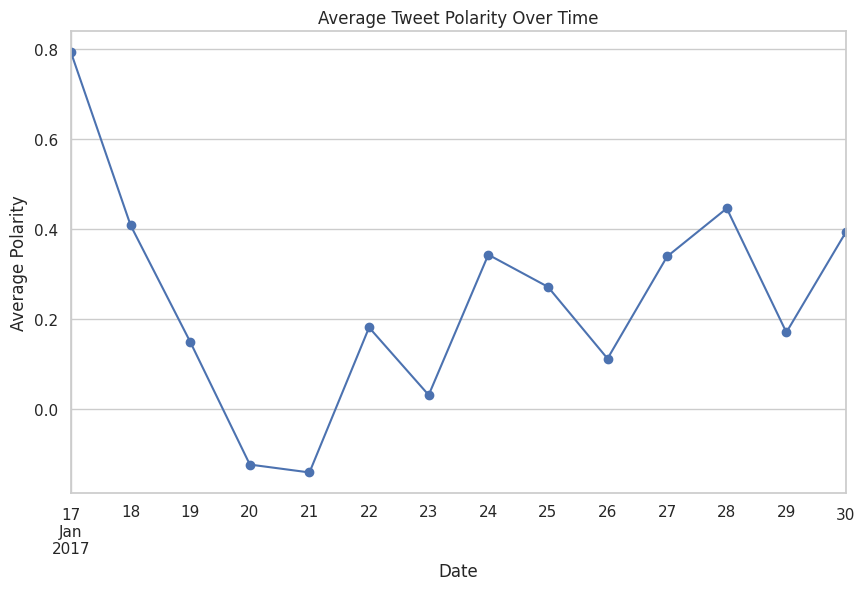

,TweetID,CleanedText,Polarity,Subjectivity,SentimentCategory
0,824217142681862144,rt our is and tag 5 of your friends to win...,0.80,0.4,Positive
1,824218047707652096,,0.00,0.0,Neutral
2,824218070931492864,rt our is and tag 5 of your friends to win...,0.80,0.4,Positive
3,824219424135598080,join in,0.00,0.0,Neutral
4,824220271393443840,if i were to win this id love to take on thi...,0.65,0.5,Positive


In [ ]:
# ============================================
# STEP 3: VISUALIZE SENTIMENT DISTRIBUTION
# ============================================

# Sentiment Category Counts
sns.countplot(data=tweets_unique, x='SentimentCategory', order=['Positive', 'Neutral', 'Negative'])
plt.title("Tweet Sentiment Distribution")
plt.ylabel("Number of Tweets")
plt.xlabel("Sentiment")
plt.show()

# Sentiment Polarity Over Time
tweets_unique['TweetDate'] = pd.to_datetime(tweets_unique['TweetDate'])
tweets_unique.set_index('TweetDate').resample('D')['Polarity'].mean().plot(kind='line', marker='o')
plt.title("Average Tweet Polarity Over Time")
plt.ylabel("Average Polarity")
plt.xlabel("Date")
plt.show()

# Preview updated dataframe
tweets_unique[['TweetID', 'CleanedText', 'Polarity', 'Subjectivity', 'SentimentCategory']].head()


In [ ]:
# ============================================
# STEP 1: PREP RETWEET COUNTS FROM RETWEET DATA
# ============================================

# Ensure column names are correct
retweets_df = retweets_df_raw[1:].copy()
retweets_df.columns = retweets_df_raw.iloc[0]
retweets_df = retweets_df.rename(columns={'Vertex 2': 'OriginalTweetID'})  # Tweet that was retweeted

# Count how many times each Tweet ID was retweeted
retweet_counts = retweets_df['OriginalTweetID'].value_counts().reset_index()
retweet_counts.columns = ['TweetID', 'RetweetCount']
retweet_counts['TweetID'] = retweet_counts['TweetID'].astype(str)  # Match format

# Also convert main dataset's TweetID to string for merging
tweets_unique['TweetID'] = tweets_unique['TweetID'].astype(str)

# Merge retweet counts into tweets_unique
tweets_with_retweets = tweets_unique.merge(retweet_counts, on='TweetID', how='left')
tweets_with_retweets['RetweetCount'] = tweets_with_retweets['RetweetCount'].fillna(0).astype(int)

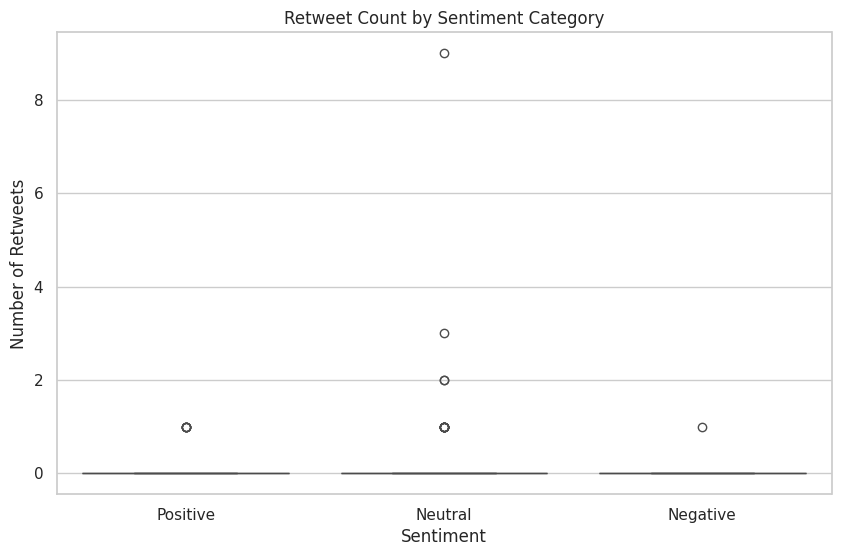

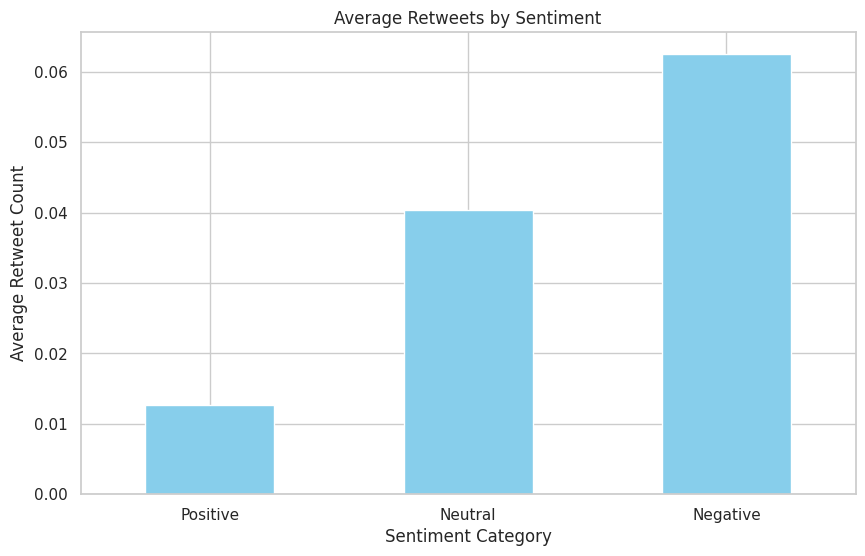

,TweetID,SentimentCategory,RetweetCount
0,824217142681862144,Positive,0
1,824218047707652096,Neutral,0
2,824218070931492864,Positive,0
3,824219424135598080,Neutral,0
4,824220271393443840,Positive,0


In [ ]:
# ============================================
# STEP 2: ANALYZE RETWEETS BY SENTIMENT
# ============================================

# Boxplot: Retweets by Sentiment Category
sns.boxplot(data=tweets_with_retweets, x='SentimentCategory', y='RetweetCount', order=['Positive', 'Neutral', 'Negative'])
plt.title("Retweet Count by Sentiment Category")
plt.ylabel("Number of Retweets")
plt.xlabel("Sentiment")
plt.show()

# Bar plot: Average retweets per sentiment
avg_retweets = tweets_with_retweets.groupby('SentimentCategory')['RetweetCount'].mean().reindex(['Positive', 'Neutral', 'Negative'])
avg_retweets.plot(kind='bar', color='skyblue')
plt.title("Average Retweets by Sentiment")
plt.ylabel("Average Retweet Count")
plt.xlabel("Sentiment Category")
plt.xticks(rotation=0)
plt.show()

# Preview result
tweets_with_retweets[['TweetID', 'SentimentCategory', 'RetweetCount']].head()


In [ ]:
# ============================================
# STEP 1: BUILD RETWEET NETWORK
# ============================================

# Use cleaned retweet dataframe
retweets_df_cleaned = retweets_df_raw[1:].copy()
retweets_df_cleaned.columns = retweets_df_raw.iloc[0]
retweets_df_cleaned = retweets_df_cleaned.rename(columns={
    'Vertex 1': 'Retweeter',
    'Vertex 2': 'OriginalTweetID'
})

# Map TweetID → User from tweets_df
tweet_author_map = tweets_df[['TweetID', 'User']].drop_duplicates().copy()
tweet_author_map['TweetID'] = tweet_author_map['TweetID'].astype(str)
retweets_df_cleaned['OriginalTweetID'] = retweets_df_cleaned['OriginalTweetID'].astype(str)

retweets_df_cleaned = retweets_df_cleaned.merge(
    tweet_author_map,
    left_on='OriginalTweetID',
    right_on='TweetID',
    how='left'
)

retweets_df_cleaned = retweets_df_cleaned.rename(columns={'User': 'OriginalAuthor'})

# Drop nulls (retweets of tweets not found in main data)
retweets_df_cleaned = retweets_df_cleaned.dropna(subset=['Retweeter', 'OriginalAuthor'])

# Remove self-loops
retweets_df_cleaned = retweets_df_cleaned[
    retweets_df_cleaned['Retweeter'].str.lower().str.strip() !=
    retweets_df_cleaned['OriginalAuthor'].str.lower().str.strip()
]

# Create directed graph
G_retweet = nx.DiGraph()
edges_retweet = list(zip(retweets_df_cleaned['Retweeter'], retweets_df_cleaned['OriginalAuthor']))
G_retweet.add_edges_from(edges_retweet)

In [ ]:
# ============================================
# STEP 2: COMPUTE CENTRALITY METRICS
# ============================================

degree_centrality = nx.degree_centrality(G_retweet)
in_degree = G_retweet.in_degree()
out_degree = G_retweet.out_degree()
betweenness = nx.betweenness_centrality(G_retweet)
closeness = nx.closeness_centrality(G_retweet)

centrality_df = pd.DataFrame({
    'User': list(degree_centrality.keys()),
    'DegreeCentrality': list(degree_centrality.values()),
    'InDegree': [in_degree[n] for n in G_retweet.nodes()],
    'OutDegree': [out_degree[n] for n in G_retweet.nodes()],
    'Betweenness': [betweenness[n] for n in G_retweet.nodes()],
    'Closeness': [closeness[n] for n in G_retweet.nodes()]
})

# ============================================
# STEP 3: BOT DETECTION (Simple Rule-Based)
# ============================================

# Count how many times each user appears in tweets_df
user_activity = tweets_df['User'].value_counts().reset_index()
user_activity.columns = ['User', 'TweetCount']

# Flag users with more than 100 tweets as potential bots
user_activity['IsBot'] = user_activity['TweetCount'] > 100

# Merge bot flags into centrality
centrality_df = centrality_df.merge(user_activity, on='User', how='left')
centrality_df['TweetCount'] = centrality_df['TweetCount'].fillna(0).astype(int)
centrality_df['IsBot'] = centrality_df['IsBot'].fillna(False)

# ============================================
# STEP 4: DISPLAY TOP USERS
# ============================================

top_influencers = centrality_df.sort_values(by='InDegree', ascending=False).head(10)
top_bridges = centrality_df.sort_values(by='Betweenness', ascending=False).head(10)

print("Top Influencers (by InDegree):")
print(top_influencers[['User', 'InDegree', 'TweetCount', 'IsBot']])

print("\nTop Bridges (by Betweenness):")
print(top_bridges[['User', 'Betweenness', 'TweetCount', 'IsBot']])


Top Influencers (by InDegree):
              User  InDegree  TweetCount  IsBot
3       thexoxoday        18          60  False
37  deepakberiwala         2           6  False
44    vineetsonkar         2          18  False
18    kajol_saxena         1           9  False
40       salesgasm         1          26  False
5      epicangel40         1          13  False
1     mgossipqueen         1          11  False
20       rehanak55         1          16  False
22          shwtz7         1         104   True
35          reyen7         1           1  False

Top Bridges (by Betweenness):
                 User  Betweenness  TweetCount  IsBot
0  824287865563533312          0.0           0  False
1        mgossipqueen          0.0          11  False
2  824479464637599744          0.0           0  False
3          thexoxoday          0.0          60  False
4  824523231017082880          0.0           0  False
5         epicangel40          0.0          13  False
6  824213427224616960          0

<ipython-input-17-bd574346b76c>:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  centrality_df['IsBot'] = centrality_df['IsBot'].fillna(False)


In [ ]:
# ============================================
# STEP 1: PREPARE MENTION DATA FROM TWEETS_DF
# ============================================

# Ensure we have the right version (multi-row, not deduplicated)
mention_df = tweets_df.copy()

# Normalize usernames
mention_df['User'] = mention_df['User'].str.lower().str.strip()
mention_df['TargetUser'] = mention_df['TargetUser'].str.lower().str.strip()

# Remove self-mentions
mention_df = mention_df[mention_df['User'] != mention_df['TargetUser']]

# Drop any nulls in user columns
mention_df = mention_df.dropna(subset=['User', 'TargetUser'])

In [ ]:
# ============================================
# STEP 2: BUILD MENTION NETWORK
# ============================================

G_mention = nx.DiGraph()
edges_mention = list(zip(mention_df['User'], mention_df['TargetUser']))
G_mention.add_edges_from(edges_mention)

# ============================================
# STEP 3: COMPUTE CENTRALITY METRICS
# ============================================

mention_in_degree = dict(G_mention.in_degree())
mention_out_degree = dict(G_mention.out_degree())
mention_betweenness = nx.betweenness_centrality(G_mention)
mention_closeness = nx.closeness_centrality(G_mention)

mention_metrics_df = pd.DataFrame({
    'User': list(G_mention.nodes()),
    'MentionInDegree': [mention_in_degree[u] for u in G_mention.nodes()],
    'MentionOutDegree': [mention_out_degree[u] for u in G_mention.nodes()],
    'MentionBetweenness': [mention_betweenness[u] for u in G_mention.nodes()],
    'MentionCloseness': [mention_closeness[u] for u in G_mention.nodes()]
})

In [ ]:
# ============================================
# STEP 4: SHOW MOST MENTIONED & MOST ACTIVE USERS
# ============================================

most_mentioned = mention_metrics_df.sort_values(by='MentionInDegree', ascending=False).head(10)
most_active = mention_metrics_df.sort_values(by='MentionOutDegree', ascending=False).head(10)

print("Top 10 Most Mentioned Users:")
print(most_mentioned[['User', 'MentionInDegree']])

print("\nTop 10 Most Active Taggers:")
print(most_active[['User', 'MentionOutDegree']])

Top 10 Most Mentioned Users:
                User  MentionInDegree
1         thexoxoday              248
23          dewcool2               38
54     iheartcontest               15
108    pinkydholakia               14
44     contestmantra               14
55      contesttable               14
52             broke               13
53    photo_contests               13
62   contestadventur               12
101   india4contests               12

Top 10 Most Active Taggers:
                 User  MentionOutDegree
62    contestadventur              1938
2261           shwtz7                66
1          thexoxoday                50
240       girija_kriz                36
2187        nehalroys                27
307          kumar623                26
2249    shraddha_bari                25
251      blessedkamal                25
270   karrivinodkumar                24
2248  pratima_talreja                19


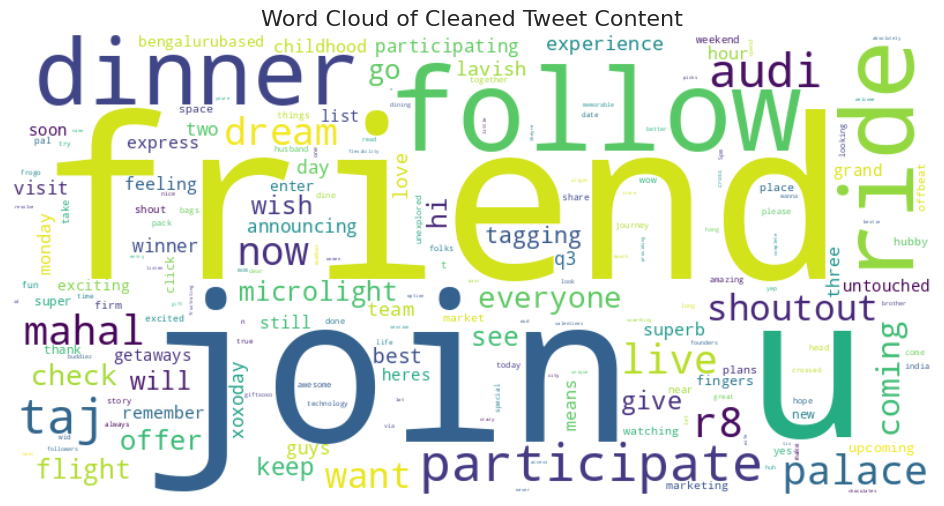

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# ============================================
# STEP 1: PREPARE TEXT FOR WORD CLOUD
# ============================================

# Combine all cleaned tweet texts into one string
all_text = ' '.join(tweets_unique['CleanedText'].dropna())

# Optional: Extend stopwords if needed
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['rt', 'https', 'amp', 'win', 'contest', 'tag'])  # common noise in this dataset

# ============================================
# STEP 2: GENERATE WORD CLOUD
# ============================================

wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=custom_stopwords, collocations=False).generate(all_text)

# ============================================
# STEP 3: PLOT THE WORD CLOUD
# ============================================

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Tweet Content", fontsize=16)
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# ============================================
# STEP 1: TF-IDF VECTORIZATION
# ============================================

# Limit max_features to keep it manageable; adjust as needed
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(tweets_unique['CleanedText'])

# Store terms for interpretation
terms = vectorizer.get_feature_names_out()

# ============================================
# STEP 2: K-MEANS CLUSTERING
# ============================================

# You can change number of clusters based on elbow method or desired granularity
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Assign clusters back to the dataset
tweets_unique['Cluster'] = kmeans.labels_

# ============================================
# STEP 3: PRINT TOP WORDS PER CLUSTER
# ============================================

def print_top_terms_per_cluster(kmeans_model, terms, n_terms=10):
    for i, center in enumerate(kmeans_model.cluster_centers_):
        top_indices = center.argsort()[-n_terms:][::-1]
        top_terms = [terms[ind] for ind in top_indices]
        print(f"Cluster {i}: {', '.join(top_terms)}")

print_top_terms_per_cluster(kmeans, terms)

Cluster 0: join, rt, friends, dinner, contest, wud, wow, yep, xoxoday, youre
Cluster 1: rt, follow, tag, friends, participate, contest, shoutout, coming, win, wants
Cluster 2: audi, taj, r8, dinner, ride, mahal, palace, dream, friends, tag
Cluster 3: microlight, flight, hi, offer, check, ride, win, rt, yep, wud
Cluster 4: experience, bengalurubased, market, offbeat, enter, marketing, plans, firm, enters, xoxoday


<ipython-input-23-b59c1cb3c832>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


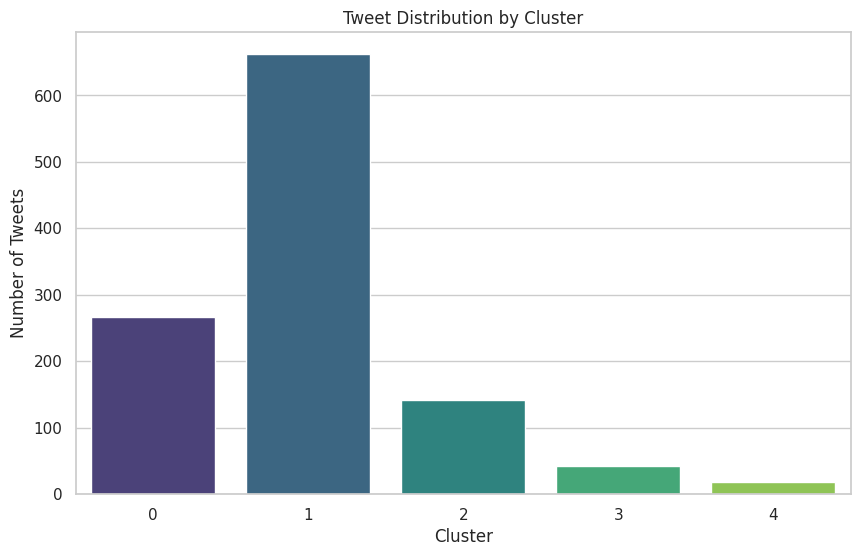

In [ ]:
# Count tweets per cluster
cluster_counts = tweets_unique['Cluster'].value_counts().sort_index()

# Bar chart
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title("Tweet Distribution by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Show 2 tweets from each cluster
for cluster_num in range(tweets_unique['Cluster'].nunique()):
    print(f"\n📌 Cluster {cluster_num} Example Tweets:")
    sample = tweets_unique[tweets_unique['Cluster'] == cluster_num]['CleanedText'].dropna().head(2)
    for i, text in enumerate(sample):
        print(f"{i+1}. {text}")


📌 Cluster 0 Example Tweets:
1. join in
2. join here

📌 Cluster 1 Example Tweets:
1. 
2. if i were to win this  id love to take  on this lavish dinner date

📌 Cluster 2 Example Tweets:
1. rt  our  is   and tag 5 of your friends to win this dream ride on an audi r8 and a dinner at taj mahal palace
2. rt  our  is   and tag 5 of your friends to win this dream ride on an audi r8 and a dinner at taj mahal palace

📌 Cluster 3 Example Tweets:
1. hi  check this offer to win microlight flight from  while you ride   see how
2. hi  check this offer to win microlight flight from  while you ride   see how

📌 Cluster 4 Example Tweets:
1. rt   love to experience  the new experience with my hubby
2. love to experience  the new experience with my hubby


In [ ]:
# Create a summary count table
cluster_summary = tweets_unique.groupby('Cluster')['SentimentCategory'].value_counts().unstack().fillna(0)
cluster_summary['TotalTweets'] = cluster_summary.sum(axis=1)
cluster_summary = cluster_summary.sort_values(by='TotalTweets', ascending=False)

# Show the summary
print("📊 Cluster Summary (Sentiment Distribution):")
print(cluster_summary)

📊 Cluster Summary (Sentiment Distribution):
SentimentCategory  Negative  Neutral  Positive  TotalTweets
Cluster                                                    
1                       6.0    374.0     282.0        662.0
0                       0.0    266.0       0.0        266.0
2                       0.0      1.0     141.0        142.0
3                       0.0      0.0      42.0         42.0
4                      10.0      3.0       6.0         19.0
